In [ ]:
!pip install speechrecognition


     --------------------------------------- 32.8/32.8 MB 23.3 MB/s eta 0:00:00


In [ ]:
!pip install pyaudio


     -------------------------------------- 164.1/164.1 kB 5.0 MB/s eta 0:00:00


Say something!
result2:
{   'alternative': [   {'confidence': 0.79748815, 'transcript': 'hello'},
                       {'transcript': 'Halo'},
                       {'transcript': 'low'},
                       {'transcript': 'no'}],
    'final': True}
Google Speech Recognition thinks you said: hello
1/1 [==============================] - 1s 587ms/step
Male, (25 - 32) Sad
Frame rate: 0.04 fps


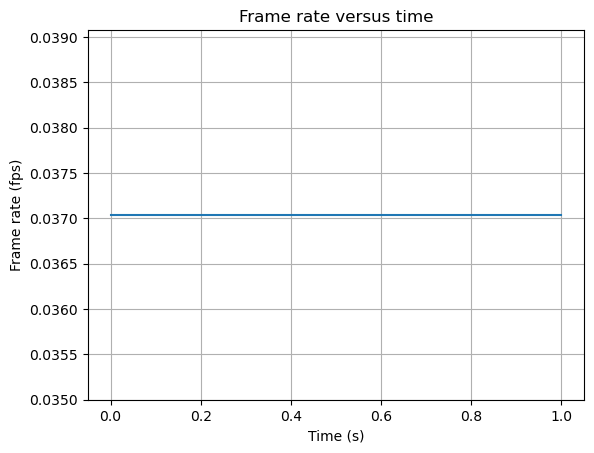

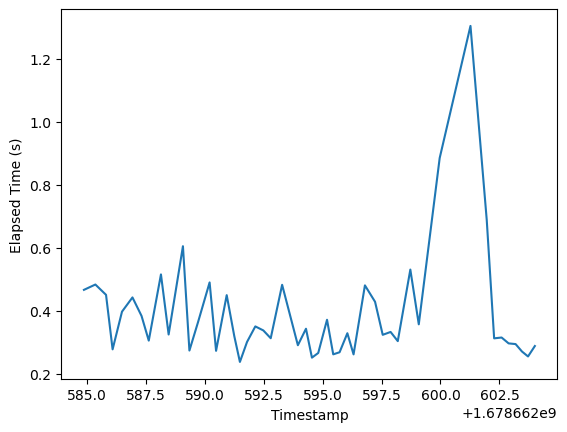

In [ ]:
import cv2
import time
import sys
import logging as log
import datetime as dt
from time import sleep
import numpy as np
from keras.models import load_model
import os
import matplotlib.pyplot as plt


casc_Path = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(casc_Path)
log.basicConfig(filename='webcam.log',level=log.INFO)

video_capture = cv2.VideoCapture(0)
anterior = 0

feature_parameters = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

parameters = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

color = np.random.randint(0,255,(100,3))

ret, old_frame = video_capture.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_parameters)

mask = np.zeros_like(old_frame)

i=1
Path='./frame.jpg'
num_frames = 0
start_time = time.time()
fps_values = []
jitter_list = []
fps_list = []
timestamp_list = []
elapsed_time_list = []

import speech_recognition as sr

# create a recognizer object
r = sr.Recognizer()
with sr.Microphone() as source:
    print("Say something!")
    audio = r.listen(source)

# recognize speech using Google Speech Recognition
try:
    print("Google Speech Recognition thinks you said: " + r.recognize_google(audio))
except sr.UnknownValueError:
    print("Google Speech Recognition could not understand audio")
except sr.RequestError as e:
    print("Could not request results from Google Speech Recognition service; {0}".format(e))




while True:
    if not video_capture.isOpened():
        print('Unable to load camera.')
        sleep(5)
        pass

    # Capture frame-by-frame
    ret, frame = video_capture.read()

    timer = cv2.getTickCount()

  

   
    #video_capture.read()
    if not ret:
        break
    

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, gray, p0, None, **parameters)

    good_new = p1[st==1]
    good_old = p0[st==1]

    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        (a,b) = tuple(map(int, (a,b)))
        (c,d) = tuple(map(int, (c,d)))
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)
    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    old_gray = gray.copy()
    p0 = good_new.reshape(-1,1,2)

    

    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )



    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        face_img = gray[y:y+h, x:x+w]
        accuracy = cv2.Laplacian(face_img, cv2.CV_64F).var()
        cv2.putText(frame, f"Accuracy: {int(accuracy)}", (10, frame.shape[0]-70), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    

    if anterior != len(faces):
        anterior = len(faces)
        log.info("faces: "+str(len(faces))+" at "+str(dt.datetime.now()))
        

            

    
    if cv2.waitKey(1) & 0xFF == ord('q'):#quite
        if os.path.isfile(Path)==True:
            os.remove(Path)
        break


        


    

    # age prediction 
    def ages(blobs):
        ageProto = "age_deploy.prototxt"
        ageModel = "age_net.caffemodel"
        ageNet = cv2.dnn.readNet(ageModel, ageProto)

        ageList = ['(0 - 2)', '(4 - 6)', '(8 - 12)', '(15 - 20)', '(25 - 32)', '(38 - 43)', '(48 - 53)', '(60 - 100)']
        ageNet.setInput(blobs)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]
        # print("Age Output : {}".format(agePreds))
        #print("Age : {}".format(age))
        return age


    #Gender Prediction
    def Gender(blobs):
        genderProto = "gender_deploy.prototxt"
        genderModel = "gender_net.caffemodel"
        genderNet= cv2.dnn.readNet(genderModel, genderProto)
        genderList = ['Male', 'Female']
        genderNet.setInput(blobs)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        # print("Gender Output : {}".format(genderPreds))
        #print("Gender : {}".format(gender))
        return gender

    #Display Age  and Gender
    MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
    blob = cv2.dnn.blobFromImage(frame, 1, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
    age=ages(blob)
    gender= Gender(blob)
    
 

    label = "{}, {}".format(gender, age)
    timestamp_list.append(time.time())
    if len(timestamp_list) > 1:
        fps = 1.0 / (timestamp_list[-1] - timestamp_list[-2])
        fps_list.append(fps)
        cv2.putText(frame, "FPS: {:.2f}".format(fps), (10, frame.shape[0]-10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    if len(timestamp_list) > 1:
        elapsed_time = timestamp_list[-1] - timestamp_list[-2]
        elapsed_time_list.append(elapsed_time)
        




    for (x, y, w, h) in faces:
        cv2.putText(frame, label, (x, y-20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 3, cv2.LINE_AA)
        if len(fps_list) > 1:
            avg_fps = sum(fps_list) / len(fps_list)
            frame_time = 1.0 / avg_fps
            for i in range(1, len(timestamp_list)):
                actual_time = timestamp_list[i] - timestamp_list[i - 1]
                jitter = abs(actual_time - frame_time)
                jitter_list.append(jitter)
            if jitter_list:
                avg_jitter = sum(jitter_list) / len(jitter_list)
                cv2.putText(frame, "Jitter: {:.2f} ms".format(avg_jitter * 1000), (10, frame.shape[0]-40),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        


   
   
    
    #Display emotion
    def Emotion(paths):
        emotion_dict = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
        model =load_model("model.h5")
        face_image  = cv2.imread(paths)
        face_image = cv2.resize(face_image, (48,48))
        face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
        face_image = np.reshape(face_image, [1, face_image.shape[0], face_image.shape[1], 1])
        predicted_class = np.argmax(model.predict(face_image))
        label_map = dict((v,k) for k,v in emotion_dict.items())
        predicted_label = label_map[predicted_class]

        print(label,predicted_label)
        return predicted_label

 
   
    if cv2.waitKey(1) & 0xFF == ord('c'):#Capture
        A=cv2.imwrite(Path.format(i),frame)
    

        if A==True:
            try:
                img = cv2.imread(Path,cv2.COLOR_BGR2GRAY)
             
                Emotion_label=Emotion(Path)
                
                cv2.putText(img, Emotion_label, (11, 22), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 3, cv2.LINE_AA)

                cv2.imshow("image", img)

                
            except:
                print("Error")
                
        if ret:
            cv2.imshow('frame',frame)
            num_frames += 1
            elapsed_time = time.time() - start_time
            fps = num_frames / elapsed_time
            fps_values.append(fps)
            fps_values.append(fps)
            print(f'Frame rate: {fps:.2f} fps')
            plt.plot(fps_values)
            plt.xlabel('Time (s)')
            plt.ylabel('Frame rate (fps)')
            plt.title('Frame rate versus time')
            plt.grid()
            plt.pause(0.01)
            
            plt.plot(timestamp_list[1:], elapsed_time_list)
            plt.xlabel('Timestamp')
            plt.ylabel('Elapsed Time (s)')
            plt.show()
        
            

              

    
    # Display the resulting frame
    cv2.imshow('Video', frame)
    

   

# When everything is done, release the capture

video_capture.release()
cv2.destroyAllWindows()
plt.imshow(img)
